In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
path = "/content/gdrive/MyDrive/Colab Notebooks/EEG"
os.chdir(path)
os.listdir(path)

['data', 'demo2.ipynb', 'demo3.ipynb', 'demo1.ipynb']

In [ ]:
#导入数据
import numpy as np
import cv2
from cv2 import resize
from keras.utils import np_utils
img_size = 200

X_data = []
Y_data = []
index = 0
g = os.listdir("data/")
for filename in g:
  index=index+1
  data = np.load("data/"+filename)
  x = data['x']
  y = data['y']
  if index == 1:
    X_data = x
    Y_data = y
  else:
    X_data = np.concatenate((X_data,x),axis=0)
    Y_data = np.concatenate((Y_data,y),axis=0)
print(X_data.shape)
print(Y_data.shape)

# 打乱数据
xdata = X_data
ydata = Y_data
num = len(ydata)
index = np.arange(num)
np.random.shuffle(index)
xdata = xdata[index,:]
ydata = ydata[index]

# one-hot编码
ydata = np_utils.to_categorical(ydata)
in_shp = list(xdata.shape[1:])
length = in_shp[1]
chanal = in_shp[0]
print(xdata.shape)
print(ydata.shape)

(42308, 3000, 1)
(42308,)
(42308, 3000, 1)
(42308, 5)


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras import backend as K
from keras import backend

# 参数设置
kerner_num = 8
epochs = 200
num_classes = ydata.shape[1]

# 构建训练集与测试集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xdata,ydata,test_size=0.25,random_state=654)

# CNN模型
def create_model(epochs=25):
    model = Sequential()
    model.add(Conv1D(16, kerner_num, input_shape=(x_train.shape[1],1), padding='same',strides = 2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv1D(32, kerner_num, activation='relu', padding='same',strides = 2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv1D(64, kerner_num, activation='relu', padding='same',strides = 2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv1D(128, kerner_num, activation='relu', padding='same',strides = 2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model
model = create_model(epochs)
model.summary()
history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=500, verbose=2,validation_data=(x_test, y_test))

DRSN_train_score = model.evaluate(x_train, y_train, batch_size=500, verbose=0)
print('Train loss:', DRSN_train_score[0])
print('Train accuracy:', DRSN_train_score[1])
DRSN_test_score = model.evaluate(x_test, y_test, batch_size=500, verbose=0)
print('Test loss:', DRSN_test_score[0])
print('Test accuracy:', DRSN_test_score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 16)          144       
                                                                 
 dropout (Dropout)           (None, 1500, 16)          0         
                                                                 
 batch_normalization (BatchN  (None, 1500, 16)         64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 32)           4128      
                                                                 
 dropout_1 (Dropout)         (None, 750, 32)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 750, 32)          128       
 hNormalization)                                        

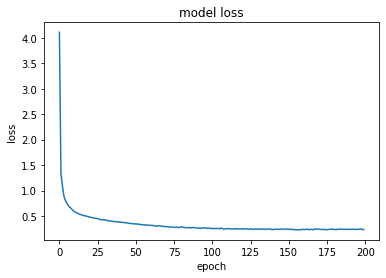

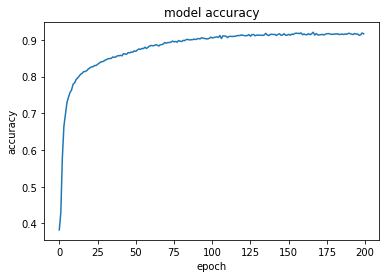

In [ ]:
# Loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

No handles with labels found to put in legend.


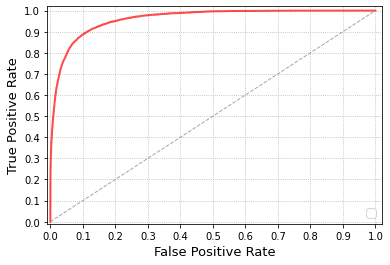

In [ ]:
from sklearn import metrics
y_score = model.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.ravel(),y_score.ravel())
plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.show()

Text(30.5, 0.5, 'true')

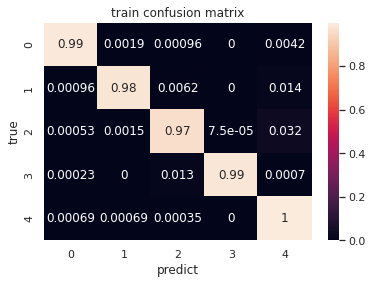

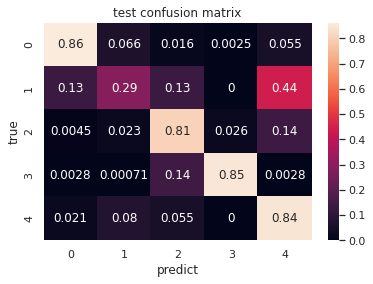

In [ ]:
pre_train = model.predict(x_train)
pre_train = np.argmax(pre_train,axis=1)
y_train = np.argmax(y_train,axis=1)
pre_test = model.predict(x_test)
pre_test = np.argmax(pre_test,axis=1)
y_test = np.argmax(y_test,axis=1)
# 评估指标
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm_train = confusion_matrix(y_train,pre_train)
cm_normalized_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
cm_test = confusion_matrix(y_test,pre_test)
cm_normalized_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
# 混淆矩阵图
sns.set()
f,ax=plt.subplots()
sns.heatmap(cm_normalized_train,annot=True,ax=ax)
ax.set_title('train confusion matrix')
ax.set_xlabel('predict') 
ax.set_ylabel('true') 

sns.set()
f,ax=plt.subplots()
sns.heatmap(cm_normalized_test,annot=True,ax=ax) 
ax.set_title('test confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 

In [ ]:
# 评估指标
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
acc = accuracy_score(y_test,pre_test)
recall = recall_score(y_test,pre_test, average='macro')
prc = precision_score(y_test,pre_test, average='macro')
f1 = f1_score(y_test,pre_test, average='macro')
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',prc)
print('F1:',f1)

Accuracy: 0.7944596766568971
Recall: 0.7303474683150215
Precision: 0.7338659210402978
F1: 0.7269052744715258
